# 07 — Comparação Final dos Modelos

Consolidação e comparação de todos os classificadores de sentimento:
1. SVM + TF-IDF (BoW)
2. SVM + Embeddings (FastText)
3. BERTimbau (fine-tuning)
4. ICL com Claude (bônus, subset)

In [1]:
import sys
sys.path.insert(0, "..")

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.config import MODELS_DIR, FIGURES_DIR, SENTIMENT_LABELS
from src.evaluation import (
    carregar_metricas,
    plotar_comparacao_modelos,
    plotar_f1_por_classe,
)

sns.set_theme(style="whitegrid", palette="Set2")
%matplotlib inline

## 1. Carregar Métricas de Todos os Modelos

In [2]:
# Carregar métricas salvas
arquivos_metricas = sorted(MODELS_DIR.glob("metricas_*.json"))

todas_metricas = []
for arq in arquivos_metricas:
    m = carregar_metricas(arq)
    todas_metricas.append(m)
    print(f"Carregado: {m['modelo']}")

print(f"\nTotal de modelos: {len(todas_metricas)}")

Carregado: BERTimbau
Carregado: ICL GPT-4o-mini
Carregado: SVM+BoW
Carregado: SVM+Embeddings

Total de modelos: 4


## 2. Tabela Consolidada

In [3]:
colunas = ["modelo", "accuracy", "f1_weighted", "precision_weighted", "recall_weighted"]
colunas_f1 = [f"f1_{l}" for l in SENTIMENT_LABELS]

df_resultados = pd.DataFrame(todas_metricas)[colunas + colunas_f1]

# Formatar para exibição
df_display = df_resultados.copy()
for col in df_display.columns:
    if col != "modelo":
        df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}")

df_display.rename(columns={
    "modelo": "Modelo",
    "accuracy": "Acurácia",
    "f1_weighted": "F1 (weighted)",
    "precision_weighted": "Precisão",
    "recall_weighted": "Recall",
    "f1_negativo": "F1 Neg",
    "f1_neutro": "F1 Neu",
    "f1_positivo": "F1 Pos",
}, inplace=True)

df_display

,Modelo,Acurácia,F1 (weighted),Precisão,Recall,F1 Neg,F1 Neu,F1 Pos
0,BERTimbau,0.8538,0.8464,0.8415,0.8538,0.8872,0.4191,0.9152
1,ICL GPT-4o-mini,0.8380,0.8454,0.8562,0.8380,0.8848,0.4571,0.9069
2,SVM+BoW,0.8170,0.8110,0.8071,0.8170,0.8461,0.3588,0.8873
3,SVM+Embeddings,0.6892,0.6919,0.6993,0.6892,0.6758,0.2382,0.7903


## 3. Gráfico de Barras — Métricas Gerais

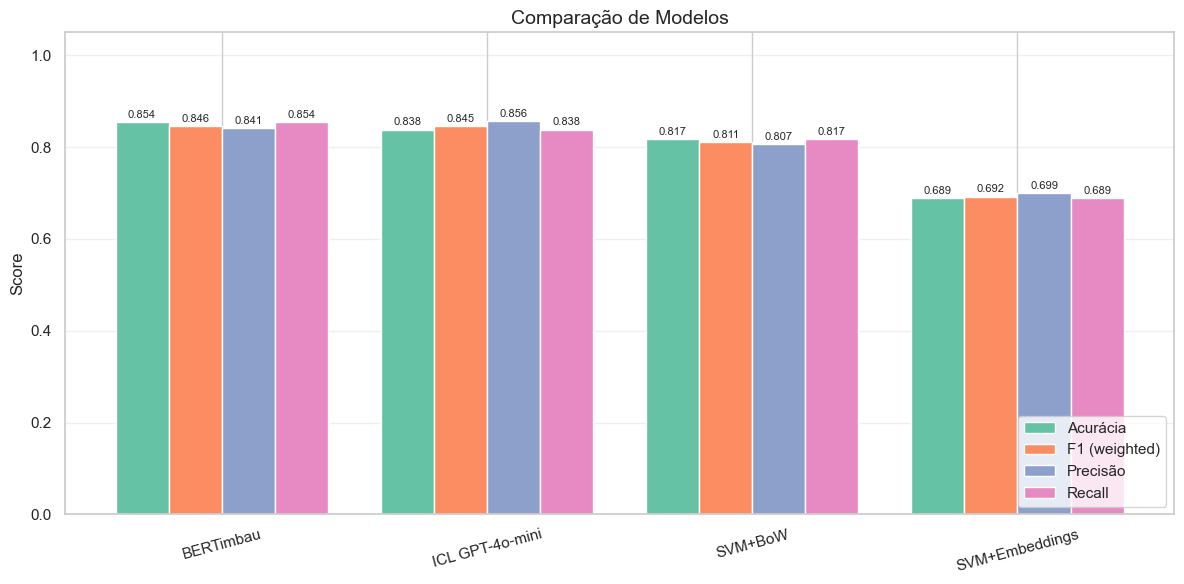

In [4]:
fig = plotar_comparacao_modelos(todas_metricas)
plt.show()

## 4. F1-Score por Classe

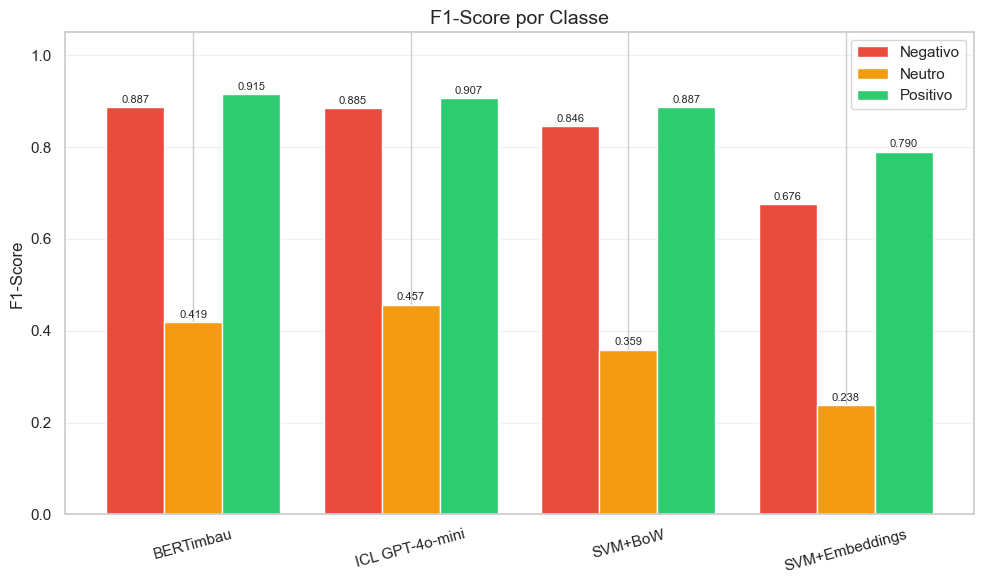

In [5]:
fig = plotar_f1_por_classe(todas_metricas)
plt.show()

## 5. Grid de Matrizes de Confusão

Nota: as matrizes de confusão individuais foram salvas nos notebooks respectivos (03, 04, 05, 06).

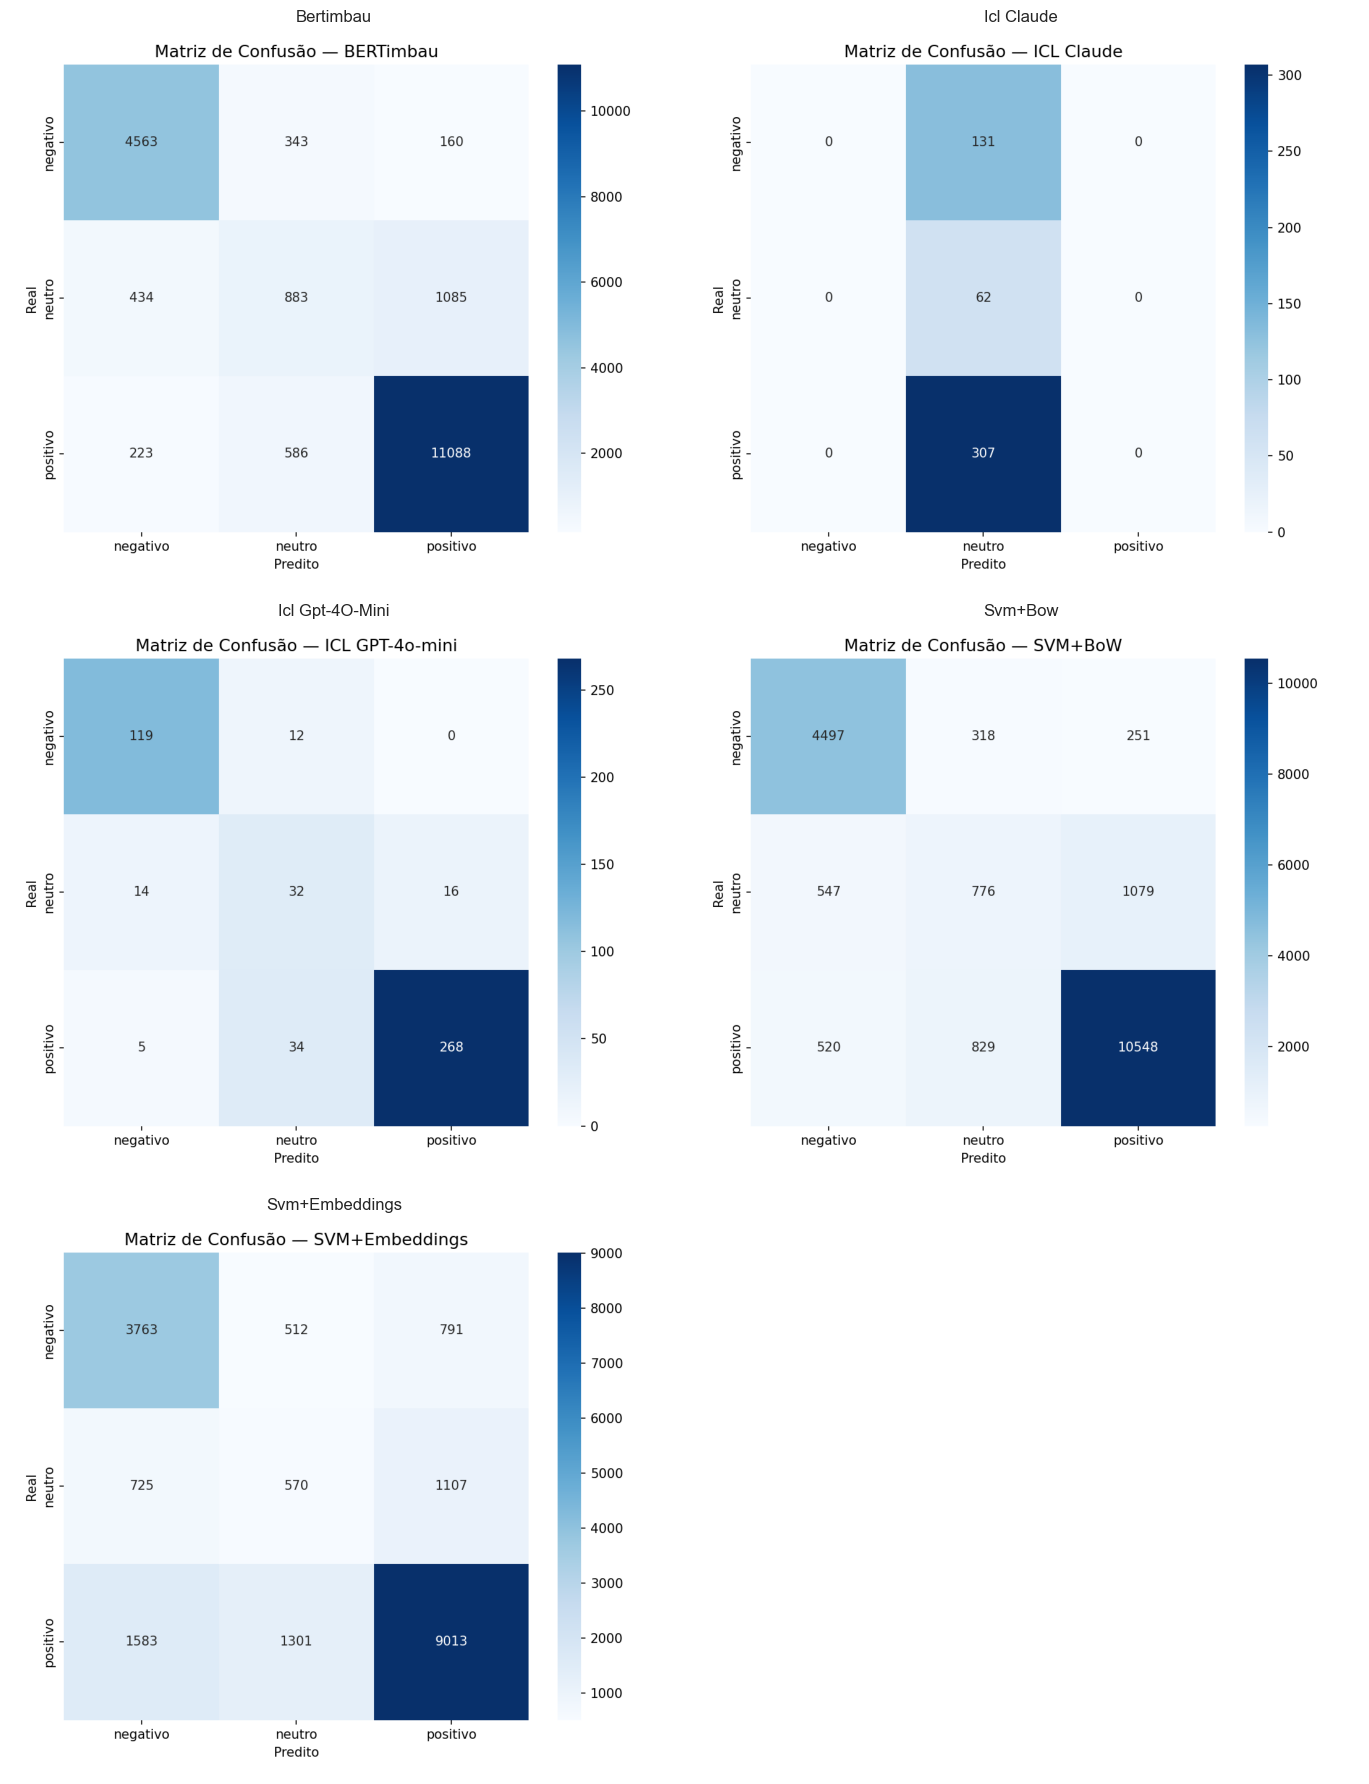

In [6]:
from pathlib import Path
from PIL import Image

cm_files = sorted(FIGURES_DIR.glob("cm_*.png"))

if cm_files:
    n = len(cm_files)
    cols = min(n, 2)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 6*rows))
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, (ax, cm_file) in enumerate(zip(axes, cm_files)):
        img = Image.open(cm_file)
        ax.imshow(img)
        ax.set_title(cm_file.stem.replace("cm_", "").replace("_", " ").title())
        ax.axis("off")
    
    # Esconder eixos vazios
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "grid_matrizes_confusao.png", dpi=150)
    plt.show()
else:
    print("Nenhuma matriz de confusão encontrada. Execute os notebooks 03-06 primeiro.")

## 6. Análise de Trade-offs

In [7]:
tradeoffs = pd.DataFrame({
    "Modelo": [m["modelo"] for m in todas_metricas],
    "F1 Weighted": [m["f1_weighted"] for m in todas_metricas],
    "Tempo Treino (estimado)": [
        "~5 min (GridSearch)",   # SVM+BoW
        "~30 min (GridSearch)",  # SVM+Emb
        "~45-90 min",            # BERT
        "N/A (inferência)",      # ICL
    ][:len(todas_metricas)],
    "Custo Computacional": [
        "Baixo (CPU)",
        "Médio (CPU)",
        "Alto (GPU/MPS)",
        "API ($)",
    ][:len(todas_metricas)],
    "Complexidade": [
        "Baixa",
        "Média",
        "Alta",
        "Baixa (prompt)",
    ][:len(todas_metricas)],
})

tradeoffs

,Modelo,F1 Weighted,Tempo Treino (estimado),Custo Computacional,Complexidade
0,BERTimbau,0.846362,~5 min (GridSearch),Baixo (CPU),Baixa
1,ICL GPT-4o-mini,0.845352,~30 min (GridSearch),Médio (CPU),Média
2,SVM+BoW,0.810983,~45-90 min,Alto (GPU/MPS),Alta
3,SVM+Embeddings,0.691884,N/A (inferência),API ($),Baixa (prompt)


## 7. Conclusões

### Principais Descobertas

1. **Desempenho por modelo**: Compare os F1-scores weighted na tabela acima
2. **Classe neutro**: Tipicamente a mais difícil de classificar para todos os modelos
3. **BERTimbau**: Esperado desempenho superior por capturar contexto semântico
4. **SVM+BoW**: Baseline forte e eficiente computacionalmente
5. **SVM+Embeddings**: Captura semântica via word embeddings pré-treinados
6. **ICL Claude**: Zero-shot/few-shot sem treinamento, custo por chamada API

### Recomendações

- Para **produção com baixo custo**: SVM + TF-IDF é a melhor opção
- Para **máxima acurácia**: BERTimbau fine-tuned
- Para **prototipagem rápida**: ICL com LLM (sem treino necessário)

### Limitações

- ICL avaliado em subset menor (500 amostras) — comparação não é direta
- Embeddings dependem da qualidade do modelo pré-treinado
- BERT requer hardware especializado para treino eficiente